In [2]:
import torch
import torch.nn.functional as F
from scipy.signal import get_window
from librosa.util import pad_center, tiny
from .util import window_sumsquare

import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named '__main__.util'; '__main__' is not a package

In [ ]:
fs = 1024
window = 'ones'
center = False

# y_list = np.load('../y_list.npy')
s = np.linspace(0,10,fs*1)
y_list = np.sin(2*np.pi*1*s, dtype=np.float32) + np.sin(2*np.pi*2*s, dtype=np.float32) \
    + np.sin(2*np.pi*4*s, dtype=np.float32) + np.sin(2*np.pi*8*s, dtype=np.float32)  
y_torch = torch.tensor(y_list, dtype=torch.float)

y_torch = torch.tensor(y_list, dtype=torch.float)

In [3]:
class STFT(torch.nn.Module):
    def __init__(self, filter_length=1024, hop_length=512, win_length=None,
                 window='hann'):
        """
        This module implements an STFT using 1D convolution and 1D transpose convolutions.
        This is a bit tricky so there are some cases that probably won't work as working
        out the same sizes before and after in all overlap add setups is tough. Right now,
        this code should work with hop lengths that are half the filter length (50% overlap
        between frames).
        
        Keyword Arguments:
            filter_length {int} -- Length of filters used (default: {1024})
            hop_length {int} -- Hop length of STFT (restrict to 50% overlap between frames) (default: {512})
            win_length {[type]} -- Length of the window function applied to each frame (if not specified, it
                equals the filter length). (default: {None})
            window {str} -- Type of window to use (options are bartlett, hann, hamming, blackman, blackmanharris) 
                (default: {'hann'})
        """
        super(STFT, self).__init__()
        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length if win_length else filter_length
        self.window = window
        self.forward_transform = None
        self.pad_amount = int(self.filter_length / 2)
        scale = self.filter_length / self.hop_length
        fourier_basis = np.fft.fft(np.eye(self.filter_length))

        cutoff = int((self.filter_length / 2 + 1))
        fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]),
                                   np.imag(fourier_basis[:cutoff, :])])
        forward_basis = torch.FloatTensor(fourier_basis[:, None, :])
        inverse_basis = torch.FloatTensor(
            np.linalg.pinv(scale * fourier_basis).T[:, None, :])

        assert(filter_length >= self.win_length)
        # get window and zero center pad it to filter_length
        fft_window = get_window(window, self.win_length, fftbins=True)
        fft_window = pad_center(fft_window, filter_length)
        fft_window = torch.from_numpy(fft_window).float()

        # window the bases
        forward_basis *= fft_window
        inverse_basis *= fft_window

        self.register_buffer('forward_basis', forward_basis.float())
        self.register_buffer('inverse_basis', inverse_basis.float())

    def transform(self, input_data):
        """Take input data (audio) to STFT domain.
        
        Arguments:
            input_data {tensor} -- Tensor of floats, with shape (num_batch, num_samples)
        
        Returns:
            magnitude {tensor} -- Magnitude of STFT with shape (num_batch, 
                num_frequencies, num_frames)
            phase {tensor} -- Phase of STFT with shape (num_batch, 
                num_frequencies, num_frames)
        """
        num_batches = input_data.shape[0]
        num_samples = input_data.shape[-1]

        self.num_samples = num_samples

        # similar to librosa, reflect-pad the input
        input_data = input_data.view(num_batches, 1, num_samples)
        
        input_data = F.pad(
            input_data.unsqueeze(1),
            (self.pad_amount, self.pad_amount, 0, 0),
            mode='reflect')
        input_data = input_data.squeeze(1)

        forward_transform = F.conv1d(
            input_data,
            self.forward_basis,
            stride=self.hop_length,
            padding=0)

        cutoff = int((self.filter_length / 2) + 1)
        real_part = forward_transform[:, :cutoff, :]
        imag_part = forward_transform[:, cutoff:, :]

        magnitude = torch.sqrt(real_part**2 + imag_part**2)
        phase = torch.atan2(imag_part.data, real_part.data)

        return magnitude, phase

    def inverse(self, magnitude, phase):
        """Call the inverse STFT (iSTFT), given magnitude and phase tensors produced 
        by the ```transform``` function.
        
        Arguments:
            magnitude {tensor} -- Magnitude of STFT with shape (num_batch, 
                num_frequencies, num_frames)
            phase {tensor} -- Phase of STFT with shape (num_batch, 
                num_frequencies, num_frames)
        
        Returns:
            inverse_transform {tensor} -- Reconstructed audio given magnitude and phase. Of
                shape (num_batch, num_samples)
        """
        recombine_magnitude_phase = torch.cat(
            [magnitude*torch.cos(phase), magnitude*torch.sin(phase)], dim=1)

        inverse_transform = F.conv_transpose1d(
            recombine_magnitude_phase,
            self.inverse_basis,
            stride=self.hop_length,
            padding=0)

        if self.window is not None:
            window_sum = window_sumsquare(
                self.window, magnitude.size(-1), hop_length=self.hop_length,
                win_length=self.win_length, n_fft=self.filter_length,
                dtype=np.float32)
            # remove modulation effects
            approx_nonzero_indices = torch.from_numpy(
                np.where(window_sum > tiny(window_sum))[0])
            window_sum = torch.from_numpy(window_sum).to(inverse_transform.device)
            inverse_transform[:, :, approx_nonzero_indices] /= window_sum[approx_nonzero_indices]

            # scale by hop ratio
            inverse_transform *= float(self.filter_length) / self.hop_length

        inverse_transform = inverse_transform[..., self.pad_amount:]
        inverse_transform = inverse_transform[..., :self.num_samples]
        inverse_transform = inverse_transform.squeeze(1)

        return inverse_transform

    def forward(self, input_data):
        """Take input data (audio) to STFT domain and then back to audio.
        
        Arguments:
            input_data {tensor} -- Tensor of floats, with shape (num_batch, num_samples)
        
        Returns:
            reconstruction {tensor} -- Reconstructed audio given magnitude and phase. Of
                shape (num_batch, num_samples)
        """
        self.magnitude, self.phase = self.transform(input_data)
        reconstruction = self.inverse(self.magnitude, self.phase)
        return reconstruction

In [5]:
from librosa.core import stft, istft

In [6]:
n_fft = 2048
hop_length = n_fft // 4
stfted = stft(y_list, n_fft, hop_length=hop_length)

In [12]:
  
#  

dura = 2.0
stft_matrix = torch.tensor(np.stack((stfted.real, stfted.imag), -1))
stft_matrix = stft_matrix[None, :, :, :]
print(stft_matrix.shape)  # ([32000])

y = istft(stfted, hop_length)
y2 = istft_torch(stft_matrix, hop_length, length=1024)

torch.Size([1, 1025, 3, 2])


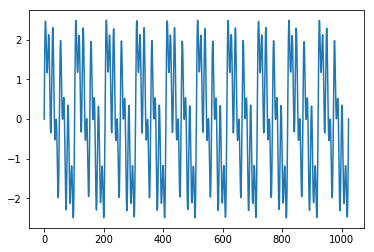

In [11]:
plt.plot(y)

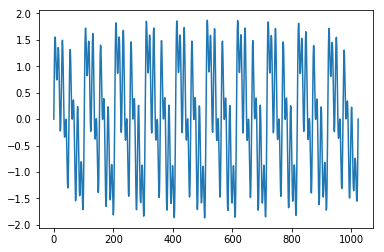

In [13]:
plt.plot(y2[0].cpu().numpy())